In [7]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import torch, diffusers
from diffusers.utils import load_image, make_image_grid

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import DDIMScheduler, PNDMScheduler
from diffusers.schedulers import KarrasDiffusionSchedulers

from tqdm.auto import tqdm

In [8]:
torch.__version__, diffusers.__version__

('2.4.1+cu121', '0.30.3')

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [10]:
# 소스를 분석할 때 사용할 코드들
# import sys
# import importlib

# diffusers 모듈 제거
# if 'diffusers' in sys.modules:
    # del sys.modules['diffusers']

# diffusers 모듈 다시 import
# importlib.reload(diffusers)

# 이제 StableDiffusionInpaintPipeline을 다시 import
# from diffusers import StableDiffusionInpaintPipeline

# 필요한 경우, StableDiffusionInpaintPipeline 클래스를 직접 다시 로드
# importlib.reload(sys.modules['diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint'])

## 테스트용 이미지 로딩

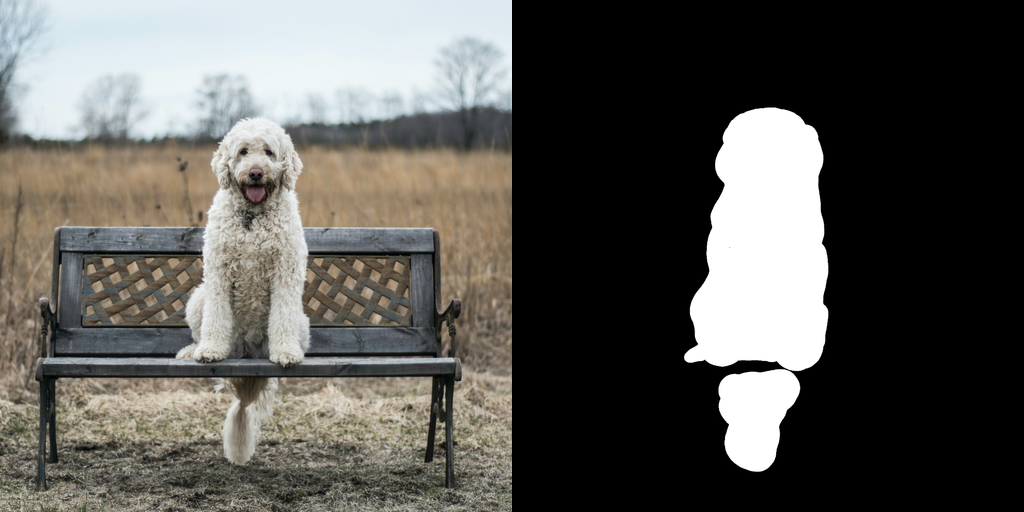

In [11]:
bench_dog_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
bench_dog_mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
bench_dog_img = load_image(bench_dog_url).resize((512, 512))
bench_dog_mask_img = load_image(bench_dog_mask_url).resize((512, 512))

# other test images
# mountain_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png"
# mountain_mask_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png"
# mountain_img = load_image(mountain_url).resize((512, 512))
# mountain_mask_img = load_image(mountain_mask_url).resize((512, 512))

# astro_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/img2img-init.png"
# astro_img = load_image(astro_url).resize((512, 512))

# cat_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/cat.png"
# cat_img = load_image(cat_url).resize((512, 512))

# save image
# bench_dog_img.save('bench_dog.png')
# bench_dog_mask_img.save('bench_dog_mask.png')
# mountain_img.save('mountain.png')
# mountain_mask_img.save('mountain_mask.png')
# astro_img.save("astro.png")
# cat_img.save("cat.png")

# make_image_grid(
#     [
#         bench_dog_img, bench_dog_mask_img,
#          mountain_img, mountain_mask_img,
#          astro_img, cat_img
#     ],
#     rows=3, cols=2
# )


make_image_grid(
    [
        bench_dog_img, bench_dog_mask_img,
    ],
    rows=1, cols=2
)


## 마스크 테스트

- 마스크 이미지의 하얀 부분이 1, 검은 부분이 0
    - 그냥 곱하면 하얀 부분만 남고, (1-mask)해서 곱하면 검은 부분이 남음
- 변수 명명 규칙
    - PIL 이미지: *_img
    - ndarray: *_np
    - torch tensor: *_ts

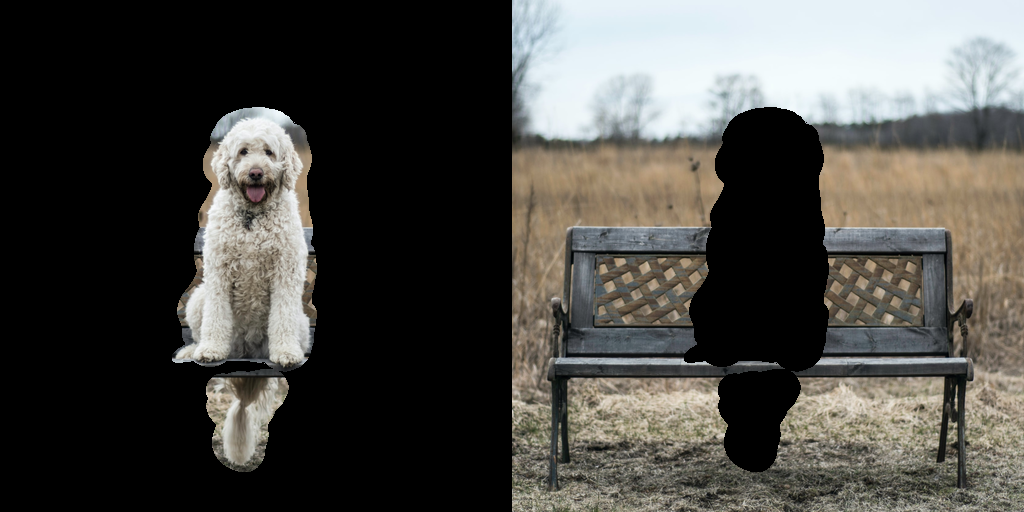

In [12]:
bench_dog_img_ts = torch.tensor( np.array(bench_dog_img).transpose(2, 0, 1) )
bench_dog_mask_ts = torch.tensor( (np.array(bench_dog_mask_img)[...,0] > 5).astype(np.float32) )

result_foreground = bench_dog_img_ts * bench_dog_mask_ts
result_foreground = Image.fromarray( 
    ((result_foreground / torch.max(result_foreground))*255).to(torch.uint8).permute(1,2,0).numpy()
)

result_background = bench_dog_img_ts * (1-bench_dog_mask_ts)
result_background = Image.fromarray( 
    ((result_background / torch.max(result_background))*255).to(torch.uint8).permute(1,2,0).numpy()
)

make_image_grid([result_foreground, result_background], rows=1, cols=2)

## Stable Diffusion 구성 요소 로딩

In [13]:
# 구성 요소 4개를 생성

# 이미지 <---> 잠재 공간을 담당하는 모델
vae = AutoencoderKL.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="vae", use_safetensors=True)

# 텍스트 컨디션을 토크나이징하는 토크나이저
tokenizer = CLIPTokenizer.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    clean_up_tokenization_spaces=False,
    subfolder="tokenizer")

# 텍스트 컨디션 인코더
text_encoder = CLIPTextModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="text_encoder", use_safetensors=True)

# 노이즈 제거 모델
unet = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="unet", use_safetensors=True
)

# 모델을 GPU로 보내기
vae.to(device)
text_encoder.to(device)
unet.to(device);

## 파라미터 설정



### 작동 모드 설정
- `PIPELINE_MODE`: Image2Image인 경우 `img2img`, 인페인팅일 경우 `inpaint`

In [31]:
PIPELINE_MODE = "inpaint"  # "img2img" or "inpaint"

- 나머지 프롬프트, 이미지 사이즈 등 설정

현재 프롬프트:  ['A small robot, high resolution, sitting on a park bench']
입력 이미지


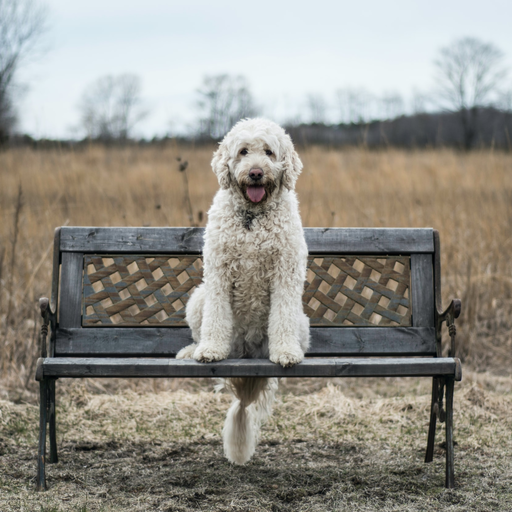

In [32]:
if PIPELINE_MODE == "img2img":
    prompt = ["An oil painting of a man on a bench"]
    base_img = bench_dog_img
else:
    prompt = ["A small robot, high resolution, sitting on a park bench"]
    base_img = bench_dog_img

height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion

num_inference_steps = 50  # Number of denoising steps
batch_size = len(prompt)

# random seed generator
generator = torch.Generator(device).manual_seed(4) # 8, 18

print("현재 프롬프트: ", prompt)
print("입력 이미지")
base_img

## 컨디션 토크나이징

In [33]:
# 토크나이저로 토크나이징
text_input = tokenizer(
    prompt, max_length=tokenizer.model_max_length,
    padding="max_length", truncation=True, return_tensors="pt"
)

# 토큰화 결과
text_input, text_input['input_ids'].shape

({'input_ids': tensor([[49406,   320,  2442,  8797,   267,  1400,  9977,   267,  4919,   525,
            320,  1452,  8771, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]])},
 torch.Size([1, 77]))

In [34]:
# 각 토큰은 768차원 벡터로 임베딩
with torch.no_grad():
    text_embeddings = text_encoder(text_input['input_ids'].to(device))[0]

text_embeddings.shape

torch.Size([1, 77, 768])

### CFG를 위한 빈 컨디션 생성

In [35]:
# max_length = text_input['input_ids'].shape[-1]

# 텍스트 컨디션이 없는 입력을 만들기 위해
# 텍스트가 모두 ""인 것으로 채워서 널 컨디션을 만듬
uncond_input = tokenizer(
    [""] * batch_size, max_length=tokenizer.model_max_length, 
    padding="max_length", truncation=True, return_tensors="pt"
)

uncond_input

{'input_ids': tensor([[49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [36]:
# 각 토큰은 768차원 벡터로 임베딩
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input['input_ids'].to(device))[0]

uncond_embeddings.shape

torch.Size([1, 77, 768])

In [37]:
# 구체적인 조건이 있는것과 그냥 깡통 조건(모두 공백인)이 같이 묶임
# (1, 77, 768), (1, 77, 768) => (2, 77, 768)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

text_embeddings.shape

torch.Size([2, 77, 768])

## 입력 이미지 준비

- 입력 이미지를 vae 통과 시켜 latent 차원으로 변환

In [38]:
# 입력 이미지를 latent 차원으로 변환
base_img_np = np.array(base_img).transpose(2, 0, 1)
init_img_np = base_img_np

# init_image_np의 latent 
init_image = torch.from_numpy(init_img_np).float() / 255.0 # 0 ~ 255 => 0 ~ 1
init_image = 2.0 * init_image - 1.0 # 0 ~ 1 => -1 ~ 1
init_image = init_image.unsqueeze(0).to(device) # add batch dim.

with torch.no_grad():
    # 0.18215는 latent 변수의 표준편차의 역수 
    # x ---> vae encoder ---> z  ===> z / sigma  인코딩된 latent를 sigma로 정규화 ----> unet 디노이징
    # 이렇게 진행되기 때문에 simga로 나누기 위해 0.18215를 곱함
    init_image_latents = vae.encode(init_image).latent_dist.sample() * vae.config.scaling_factor

init_image_latents.shape, type(init_image_latents)

(torch.Size([1, 4, 64, 64]), torch.Tensor)

- 태스크가 inpaint인 경우 마스크 이미지도 리사이즈해서 latent 차원과 맞춤

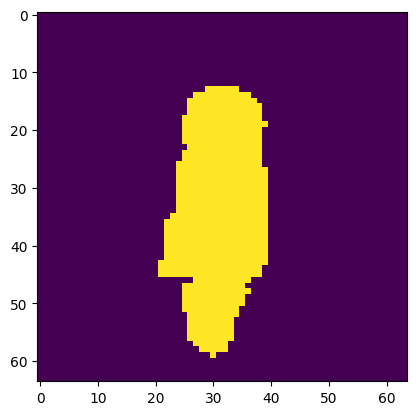

In [39]:
if PIPELINE_MODE == 'inpaint':
    # mask를 64, 64로 이미지 사이즈 변경
    mask_latent_size_img = bench_dog_mask_img.resize((64,64))
    mask_latent_size_ts = torch.tensor( (np.array(mask_latent_size_img)[...,0] > 5).astype(np.float32) )
    plt.imshow(mask_latent_size_ts.numpy())

    mask_latent_size_ts = mask_latent_size_ts.to(device)
else:
    print("No mask is required for img2img operations!!")

## 스케쥴러 세팅

In [40]:
scheduler = PNDMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
# scheduler = DDIMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

# 타임스탭 세팅
scheduler.set_timesteps(num_inference_steps)
scheduler.timesteps

tensor([981, 961, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741,
        721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461,
        441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181,
        161, 141, 121, 101,  81,  61,  41,  21,   1])

- 태스크가 img2img인 경우 `strength`를 기반으로 타임스탭 조절
- 조절된 타임스탭의 마지막 타임스탭 만큼의 노이즈를 `init_image_latents`에 추가

In [41]:
if PIPELINE_MODE == 'img2img':
    print("===================================================")
    print("IMG2IMG SETTING")
    print("===================================================")      
    # img2img 작업에서 노이즈를 얼마나 추가할지를 결정하는 강도
    strength = 0.6
    
    # strength를 기반으로 타임 스탭을 줄임 
    # 기본 50스탭 * 0.6 해서 약 30스탭
    # 타임스탭을 많이 가져가면 base image에 너무 많은 노이즈가 추가되어
    # base image가 condition 역할을 하지 못하게 됨
    # 따라서 strength를 0.1정도로 아주 작게 하면 타임 스탭이 짧아지게 되고 
    # 노이즈를 많이 추가하지 못하므로 원래 이미지가 그대로 생성됨
    # 반대의 경우는 원래 이미지는 거의 지워지고 새로운 이미지가 만들어지게 됨
    init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
    print("\n기본 설정된 타임스탭 수:", num_inference_steps)
    print("\nstrength에 의해 조정된 타임스탭 수: ", init_timestep)
    
    # 기본 50스탭일 경우 뒤 쪽 30스탭만 잘라 옴
    t_start = max(num_inference_steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:]
    print("\n조정된 후 타임스탭들: ", timesteps)
    
    # 새로 계산된 타임스탭에서 마지막 타임스탭을 가져와서 
    # base image에 노이즈를 태울 타임스탭으로 사용
    latent_timestep = timesteps[:1]
    print("\n기본 이미지에 노이즈를 추가할 타임스탭: ", latent_timestep)
    
    noise = torch.randn(init_image_latents.shape, 
                        generator=generator, 
                        device=device, dtype=torch.float32)

    # 기본 이미지가 인코딩된 latent 변수에 노이즈를 추가함
    latents = scheduler.add_noise(init_image_latents, noise, latent_timestep)

else: # inpaint 일 경우는 그냥 무작위 노이즈를 준비
    print("===================================================")
    print("INPAINT SETTING")
    print("===================================================")      
    # 순수 노이즈 잠재 변수
    latents = torch.randn(
        (batch_size, unet.config.in_channels, height // 8, width // 8),
        generator = generator,
        device=device, dtype=torch.float32)

    # 앞서 실행된 img2img 작업에서 수정된 타임스탭을 다시 세팅
    timesteps = scheduler.timesteps
    print("\n실행될 타임스탭들: ", timesteps)

print("\n준비된 입력 잠재변수 사이즈: ", latents.shape)

INPAINT SETTING

실핼될 타임스탭들:  tensor([981, 961, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741,
        721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461,
        441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181,
        161, 141, 121, 101,  81,  61,  41,  21,   1])

준비된 입력 잠재변수 사이즈:  torch.Size([1, 4, 64, 64])


In [42]:
guidance_scale = 7.5  

for i, t in enumerate(tqdm(timesteps)):
    # 텍스트 컨디션이 있는 입력과 없는 입력을 동시에 처리하기 위해 latents를 두배 확장
    latent_model_input = torch.cat([latents] * 2)
    
    # 스케쥴러가 scale 기능을 요구하면 해당 스케쥴러에 구현된 scale 함수를 실행
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # unet으로 노이즈 예측
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # 가이던스 수행
    # 모델의 출력을 두개로 나눔
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    # CFG eq(6)
    # 조건을 주고 예측한 노이즈와 조건 없이 예측한 노이즈를
    # 적당히 섞어 조금 더 조건에 가이드된 노이즈를 계산
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    # inpainting
    if PIPELINE_MODE =='inpaint' and i < len(scheduler.timesteps)-1:
        # 원본 이미지에서 마스크 되지 않은 영역에 추가할 노이즈
        noise = torch.randn(init_image_latents.shape, generator=generator, device=device, dtype=torch.float32)
        # 원본 이미지로 부터 얻어진 latent 변수에 현재 타임스탭 t-1 수준의 노이즈 추가 
        background = scheduler.add_noise(init_image_latents, noise, timesteps[i+1]) 

        # 생성된 latents에서 마스크의 흰부분만 가져옴
        latents = latents*mask_latent_size_ts
        # 원본 이미지의 latents에서 마스크의 검은 부분을 가져옴
        background = background * (1-mask_latent_size_ts)
        # 둘을 합침
        latents += background


  0%|          | 0/51 [00:00<?, ?it/s]

In [43]:
latents_norm = latents / vae.config.scaling_factor

with torch.no_grad():
    image = vae.decode(latents_norm).sample

In [44]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)

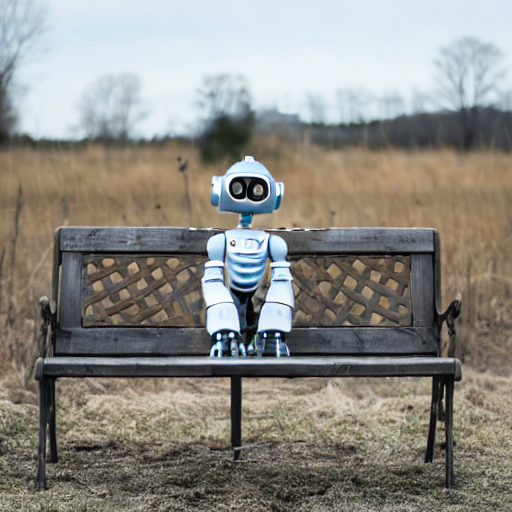

In [45]:
image

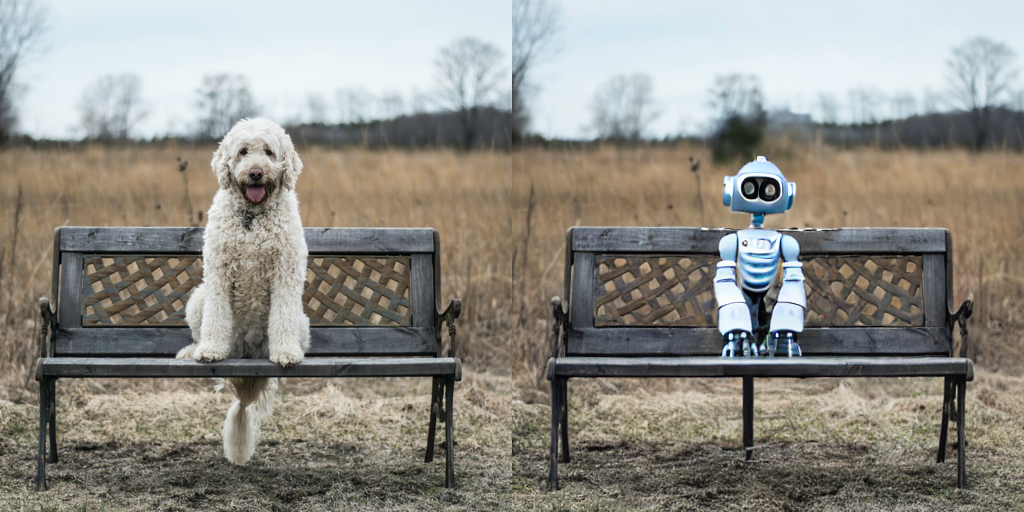

In [46]:
grid = make_image_grid([bench_dog_img, image], rows=1, cols=2)
grid

In [47]:
if PIPELINE_MODE == "inpaint":
    grid.save("grid_output_inpaint.png")
else:
    grid.save("grid_output_img2img.png")